In [1]:
import spacy

# Lade das deutsche Sprachmodell von spaCy
nlp = spacy.load("de_core_news_sm")

def extract_keywords_from_query(query, custom_stopwords=None):
    """
    Extrahiert Keywords aus einer Query durch Tokenisierung und Entfernung von Stoppwörtern.
    """
    if custom_stopwords is None:
        custom_stopwords = set(nlp.Defaults.stop_words)
    
    # Tokenisiere die Query
    doc = nlp(query.lower())
    
    # Extrahiere Keywords: Wörter, die keine Stoppwörter, Zahlen oder Satzzeichen sind
    keywords = [token.text for token in doc if token.text not in custom_stopwords and not token.is_punct and not token.like_num]
    
    return keywords


In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_wordcloud(keywords):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Keyword Word Cloud")
    plt.show()


In [3]:
import matplotlib.pyplot as plt

def visualize_distance_histogram(distances):
    plt.figure(figsize=(10, 6))
    plt.hist(distances, bins=10, color='blue', edgecolor='black')
    plt.title('Distribution of Normalized Distances')
    plt.xlabel('Normalized Distance')
    plt.ylabel('Frequency')
    plt.show()

In [5]:
import matplotlib.pyplot as plt

def visualize_scores_scatter(semantic_scores, combined_scores):
    plt.figure(figsize=(10, 6))
    plt.scatter(semantic_scores, combined_scores, color='green')
    plt.title('Semantic Scores vs. Combined Scores')
    plt.xlabel('Semantic Scores')
    plt.ylabel('Combined Scores')
    plt.show()

In [6]:
import matplotlib.pyplot as plt

def visualize_top_k_results(results):
    ids = [result['id'] for result in results]
    scores = [result['score'] for result in results]
    
    plt.figure(figsize=(12, 6))
    plt.barh(ids, scores, color='purple')
    plt.gca().invert_yaxis()  # Beste Ergebnisse oben
    plt.title('Top-k Results')
    plt.xlabel('Score')
    plt.ylabel('Document ID')
    plt.show()

In [7]:
import matplotlib.pyplot as plt

def visualize_performance(steps, times):
    plt.figure(figsize=(10, 6))
    plt.plot(steps, times, marker='o', linestyle='-', color='red')
    plt.title('Performance Analysis')
    plt.xlabel('Processing Step')
    plt.ylabel('Time (s)')
    plt.show()

In [ ]:
# Beispiel für Keyword-Visualisierung
keywords = ['entsorge', 'altglas', 'frankfurt', 'container', 'glas', 'entsorgung']
visualize_wordcloud(keywords)

# Beispiel für Distanznormalisierung
distances = [0.2, 0.3, 0.1, 0.4, 0.25, 0.3, 0.15, 0.35]
visualize_distance_histogram(distances)

# Beispiel für Scores-Scatter Plot
semantic_scores = [0.8, 0.6, 0.7, 0.9, 0.5]
combined_scores = [1.0, 0.9, 0.85, 0.95, 0.7]
visualize_scores_scatter(semantic_scores, combined_scores)

# Beispiel für Top-k Ergebnisse
results = [{'id': 'doc_0', 'score': 1.0}, {'id': 'doc_1', 'score': 0.95}, {'id': 'doc_2', 'score': 0.9}]
visualize_top_k_results(results)

# Beispiel für Performance-Analyse
steps = ['Tokenization', 'Embedding', 'Search', 'Post-Processing']
times = [0.01, 0.3, 0.5, 0.02]
visualize_performance(steps, times)

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8


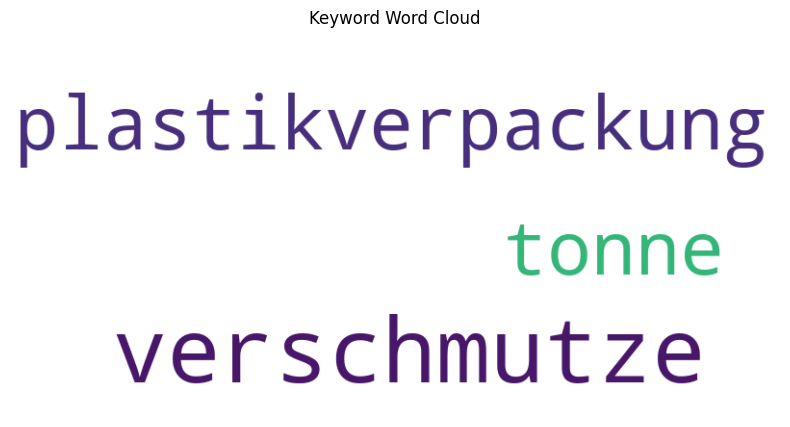

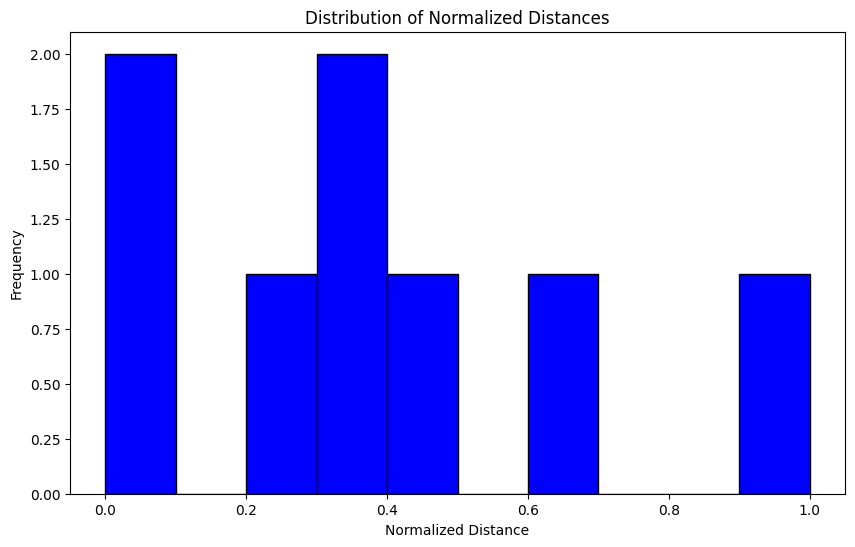

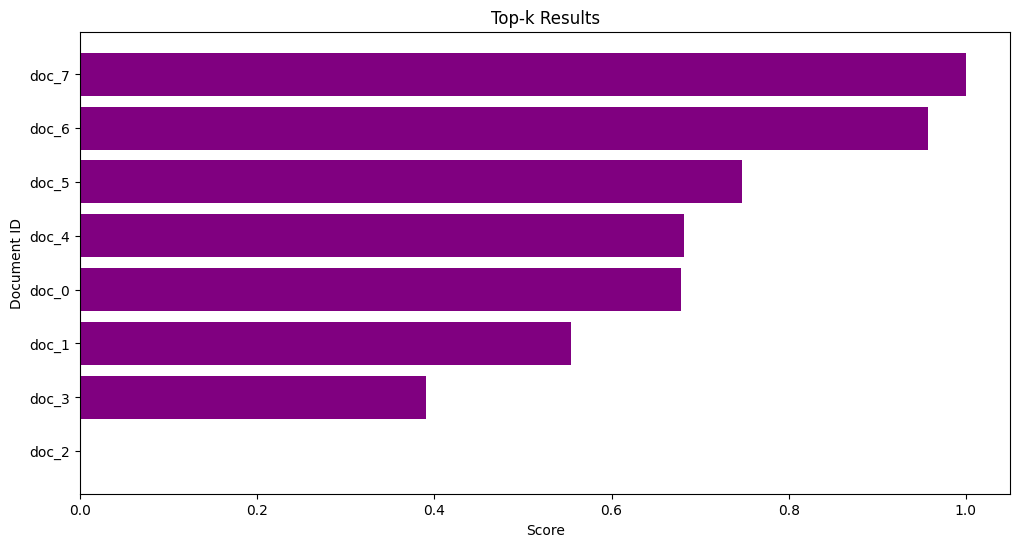

In [15]:
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings

# Lade das vortrainierte Modell
model_name = 'sentence-transformers/multi-qa-mpnet-base-dot-v1'
embedding_model = SentenceTransformer(model_name)

# Initialisiere den Chroma-Client
chroma_client = chromadb.PersistentClient(
    path="chroma_db",
    settings=Settings(),
    tenant=DEFAULT_TENANT,
    database=DEFAULT_DATABASE,
)

def hybrid_search_v6(chroma_client, query, keywords, embedding_model, collection_name="document_embeddings_v2", top_k=10):
    # 1. Semantische Suche
    query_embedding = embedding_model.encode(query).tolist()
    collection = chroma_client.get_collection(name=collection_name)
    semantic_results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k
    )
    
    # 2. Distanznormalisierung
    distances = semantic_results['distances'][0]
    min_distance = min(distances)
    max_distance = max(distances)
    normalized_distances = [(d - min_distance) / (max_distance - min_distance) for d in distances]
    
    # 3. Klassische Textsuche basierend auf Keywords
    text_search_results = []
    for i in range(len(semantic_results['ids'][0])):
        metadata = semantic_results['metadatas'][0][i]
        keyword_count = sum(keyword.lower() in metadata['text'].lower() for keyword in keywords)
        if keyword_count > 0:
            text_search_results.append({
                'id': semantic_results['ids'][0][i],
                'text': metadata['text'],
                'keywords': keywords,
                'score': 1.0 + 0.5 * keyword_count  # Gewichtung für Keywords
            })
    
    # 4. Kombination der Ergebnisse
    combined_results = []
    seen_ids = set()
    for i in range(len(semantic_results['ids'][0])):
        distance = normalized_distances[i]
        combined_score = 1.0 - distance  # Gewichtung für semantische Suche
        
        if semantic_results['ids'][0][i] not in seen_ids:
            seen_ids.add(semantic_results['ids'][0][i])
            combined_results.append({
                'id': semantic_results['ids'][0][i],
                'text': semantic_results['metadatas'][0][i]['text'] if isinstance(semantic_results['metadatas'][0][i], dict) else "",
                'keywords': keywords,
                'score': combined_score
            })
    
    for result in text_search_results:
        if result['id'] not in seen_ids:
            combined_results.append(result)
    
    # 5. Sortieren der kombinierten Ergebnisse nach Score
    combined_results.sort(key=lambda x: x['score'], reverse=True)
    
    # 6. Rückgabe der Top-k Ergebnisse und der normalisierten Distanzen
    return combined_results[:top_k], normalized_distances

# Beispielnutzung:
query5 = "Ich habe eine verschmutze Plastikverpackung, in welche Tonne kommt diese?"
# query5 = "Wie entsorge ich Altglas in Frankfurt?"

keywords5 = extract_keywords_from_query(query5)

# Durchführung der hybriden Suche mit Keywords
hybrid_results_v6, normalized_distances_v6 = hybrid_search_v6(chroma_client, query5, keywords5, embedding_model)

# Visualisierung der Ergebnisse
visualize_wordcloud(keywords5)
visualize_distance_histogram(normalized_distances_v6)
visualize_top_k_results(hybrid_results_v6)

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8


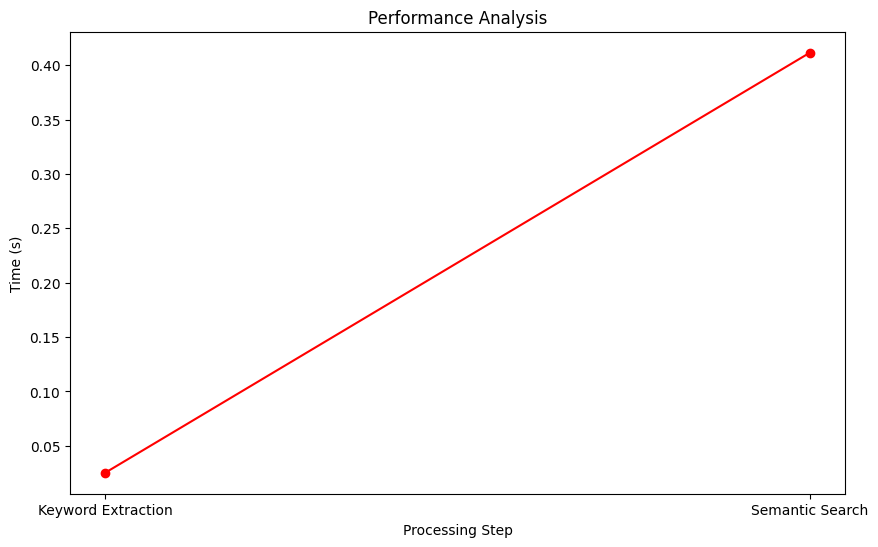

In [11]:
import time

steps = ['Keyword Extraction', 'Semantic Search', 'Distance Normalization', 'Text Search', 'Result Combination']
times = []

# Zeitmessung für die Keyword-Extraktion
start_time = time.time()
keywords5 = extract_keywords_from_query(query5)
times.append(time.time() - start_time)

# Zeitmessung für die hybride Suche
start_time = time.time()
hybrid_results_v5 = hybrid_search_v6(chroma_client, query5, keywords5, embedding_model)
times.append(time.time() - start_time)

# Visualisierung der Zeiten
visualize_performance(steps[:len(times)], times)

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8


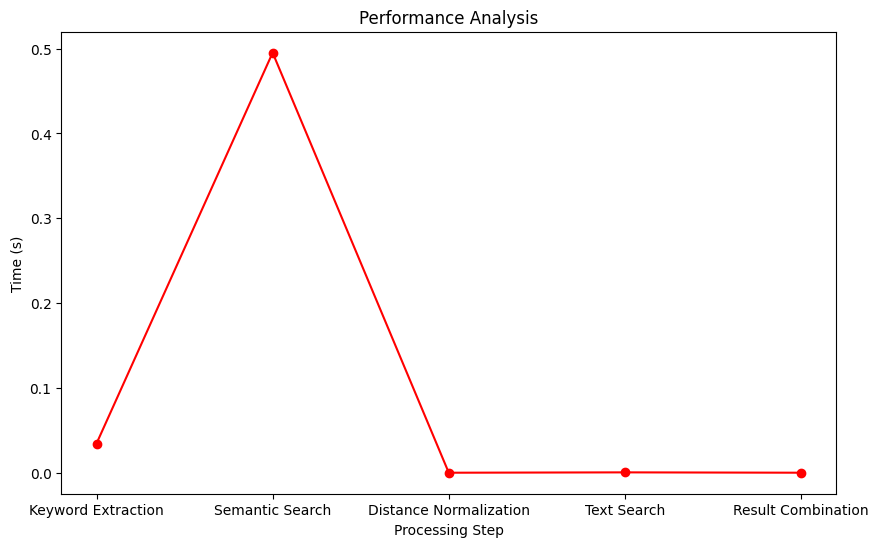

In [12]:
import time

def hybrid_search_v6_with_timing(chroma_client, query, keywords, embedding_model, collection_name="document_embeddings_v2", top_k=10):
    times = {}
    
    # 1. Semantische Suche
    start_time = time.time()
    query_embedding = embedding_model.encode(query).tolist()
    collection = chroma_client.get_collection(name=collection_name)
    semantic_results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k
    )
    times['Semantic Search'] = time.time() - start_time
    
    # 2. Distanznormalisierung
    start_time = time.time()
    distances = semantic_results['distances'][0]
    min_distance = min(distances)
    max_distance = max(distances)
    normalized_distances = [(d - min_distance) / (max_distance - min_distance) for d in distances]
    times['Distance Normalization'] = time.time() - start_time
    
    # 3. Klassische Textsuche basierend auf Keywords
    start_time = time.time()
    text_search_results = []
    for i in range(len(semantic_results['ids'][0])):
        metadata = semantic_results['metadatas'][0][i]
        keyword_count = sum(keyword.lower() in metadata['text'].lower() for keyword in keywords)
        if keyword_count > 0:
            text_search_results.append({
                'id': semantic_results['ids'][0][i],
                'text': metadata['text'],
                'keywords': keywords,
                'score': 1.0 + 0.5 * keyword_count  # Gewichtung für Keywords
            })
    times['Text Search'] = time.time() - start_time
    
    # 4. Kombination der Ergebnisse
    start_time = time.time()
    combined_results = []
    seen_ids = set()
    for i in range(len(semantic_results['ids'][0])):
        distance = normalized_distances[i]
        combined_score = 1.0 - distance  # Gewichtung für semantische Suche
        
        if semantic_results['ids'][0][i] not in seen_ids:
            seen_ids.add(semantic_results['ids'][0][i])
            combined_results.append({
                'id': semantic_results['ids'][0][i],
                'text': semantic_results['metadatas'][0][i]['text'] if isinstance(semantic_results['metadatas'][0][i], dict) else "",
                'keywords': keywords,
                'score': combined_score
            })
    
    for result in text_search_results:
        if result['id'] not in seen_ids:
            combined_results.append(result)
    
    times['Result Combination'] = time.time() - start_time
    
    # 5. Sortieren der kombinierten Ergebnisse nach Score
    combined_results.sort(key=lambda x: x['score'], reverse=True)
    
    # 6. Rückgabe der Top-k Ergebnisse, normalisierten Distanzen und Zeitmessungen
    return combined_results[:top_k], normalized_distances, times

# Beispielnutzung:
steps = ['Keyword Extraction', 'Semantic Search', 'Distance Normalization', 'Text Search', 'Result Combination']
times = []

# Zeitmessung für die Keyword-Extraktion
start_time = time.time()
keywords5 = extract_keywords_from_query(query5)
times.append(time.time() - start_time)

# Durchführung der hybriden Suche mit Zeitmessung
hybrid_results_v6, normalized_distances_v6, hybrid_times = hybrid_search_v6_with_timing(chroma_client, query5, keywords5, embedding_model)

# Füge die restlichen Zeiten hinzu
times.extend([hybrid_times[step] for step in steps[1:]])

# Visualisierung der Zeiten
visualize_performance(steps, times)

In [16]:
print(f"Query: {query5}")
print(f"Extrahierte Keywords: {keywords5}")
# Ausgabe der hybriden Suchergebnisse
for i, result in enumerate(hybrid_results_v6):
    print(f"Ergebnis {i+1}:\n")
    print(f"ID: {result['id']}")
    print(f"Text: {result['text']}")
    print(f"Keywords: {result.get('keywords', [])}")
    print(f"Score: {result['score']}")
    print("\n" + "="*50 + "\n")

Query: Ich habe eine verschmutze Plastikverpackung, in welche Tonne kommt diese?
Extrahierte Keywords: ['verschmutze', 'plastikverpackung', 'tonne']
Ergebnis 1:

ID: doc_7
Text: gelbe tonne gelben sack gehören gebrauchte restentleerte verpackungen papier glas verpackungsbestandteile trennen ausspülen menüschalen kunststoffdeckel fertiggerichten arzneimittelblister müsliriegelfolie joghurtbecher nudeltüten einkaufstüten reinigungsmittelflaschen gemüsebeutel kunststoff flüssigseife eisverpackungen fruchtpüree üllmaterial versand verpackungen shampooflaschen luftpolsterfolie spraydosen soßentüten konservendosen tierfutterdosen kronkorken zahnpastatuben kunststoffschalen lebensmittel gelbe tonne gelben sack gehören verpackungen papier pappe glas abfälle verpackungen schuhe altkleider gummi strumpfhosen batterien holzwolle styroporreste behälterglas dämmplatten blechgeschirr tapetenreste disketten keramikprodukte windeln druckerpatronen kinderspielzeug zahnbürsten klarsichthüllen zigaretten